In [1]:
from photochem import __version__
print(__version__)

0.2.6


# Using VULCAN reaction networks

This notebook shows how to use reaction networks from [VULCAN](https://github.com/exoclime/VULCAN), which is a different photochemical model.

First, we download VULCAN from Github:

In [2]:
import subprocess

subprocess.run("rm -rf ./VULCAN".split())
subprocess.run("git clone --depth=1 https://github.com/exoclime/VULCAN.git".split())
subprocess.run("rm -rf ./VULCAN/.git".split())

CompletedProcess(args=['rm', '-rf', './VULCAN/.git'], returncode=0)

Next, we use the `vulcan2yaml` function to convert the `SNCHO_full_photo_network` reaction network into the Photochem yaml format.

`vulcan2yaml` is not perfect. The main issue is that VULCAN and Photochem have different databases of photolysis cross sections. So `vulcan2yaml` only includes photolysis reactions with data.

In [3]:
from photochem.utils import vulcan2yaml

vulcan2yaml("VULCAN/thermo/SNCHO_full_photo_network.txt",\
            "VULCAN/thermo/all_compose.txt", \
            outfile = "SNCHO_full_photo_network.yaml",\
            vulcan_nasa9_data_folder="VULCAN/thermo/NASA9")

Next, we need to put together a settings file which will work with the new network. Here I use the boundary conditions in `VULCAN/atm/BC_bot_Earth.txt`.

In [4]:
settings_file = \
"""
atmosphere-grid:
  bottom: 0.0
  top: 1.0e7
  number-of-layers: 200

photolysis-grid:
  regular-grid: true
  lower-wavelength: 92.5
  upper-wavelength: 855.0
  number-of-bins: 200

planet:
  use-background-gas: true
  background-gas: N2
  surface-pressure: 1.013
  planet-mass: 5.972e27
  planet-radius: 6.371e8
  surface-albedo: 0.25
  diurnal-averaging-factor: 0.5
  solar-zenith-angle: 50.0
  diff-lim-hydrogen-escape: true
  water:
    fix-water-in-troposphere: false
    gas-rainout: true
    rainfall-rate: 1 # relative to modern earth's rainfall rate
    tropopause-altitude: 1.1e6 # cm. required if gas-rainout or fix-water-in-troposphere
    water-condensation: true
    condensation-rate: {A: 1.0e-5, rhc: 0.01, rh0: 0.015}

boundary-conditions:
- name: H2O
  lower-boundary: {type: mix, mix: 0.0175}
  upper-boundary: {type: veff, veff: 0.0}
- name: CO2
  lower-boundary: {type: mix, mix: 4e-4}
  upper-boundary: {type: veff, veff: 0.0}
- name: O2
  lower-boundary: {type: mix, mix: 0.2}
  upper-boundary: {type: veff, veff: 0.0}
- name: Ar
  lower-boundary: {type: mix, mix: 9.34e-3}
  upper-boundary: {type: veff, veff: 0.0}
- name: CO
  lower-boundary: {type: vdep + dist flux, vdep: 0.01, flux: 3.7e11, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: CH4
  lower-boundary: {type: flux, flux: 1.2e11}
  upper-boundary: {type: veff, veff: 0.0}
- name: NH3
  lower-boundary: {type: vdep + dist flux, vdep: 0.01, flux: 5.0e+10, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: N2O
  lower-boundary: {type: flux, flux: 1.0e+9}
  upper-boundary: {type: veff, veff: 0.0}
- name: "NO"
  lower-boundary: {type: vdep + dist flux, vdep: 0.016, flux: 1e9, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: NO2
  lower-boundary: {type: vdep + dist flux, vdep: 0.1, flux: 1e9, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: HCN
  lower-boundary: {type: vdep + dist flux, vdep: 0.1, flux: 4.4e+8, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2S
  lower-boundary: {type: vdep + dist flux, vdep: 0.015, flux: 2e8, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: SO2
  lower-boundary: {type: vdep + dist flux, vdep: 1, flux: 9e9, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: COS
  lower-boundary: {type: vdep + dist flux, vdep: 1, flux: 9e9, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2SO4
  lower-boundary: {type: vdep + dist flux, vdep: 1, flux: 7e8, height: 2}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2
  lower-boundary: {type: flux, flux: 1e6}
  upper-boundary: {type: veff, veff: 0.0}
"""

In [5]:
# save the settings file
from photochem.utils._format import yaml, MyDumper, Loader, FormatSettings_main, FormatReactions_main

data = yaml.load(settings_file,Loader=Loader)
data = FormatSettings_main(data)
fil = open('settings_vulcan.yaml','w')
yaml.dump(data,fil,Dumper=MyDumper,sort_keys=False,width=70)
fil.close()

Now we have everything we need to do a calculation

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from photochem import Atmosphere, zahnle_earth

In [7]:
pc = Atmosphere('SNCHO_full_photo_network.yaml',\
                "settings_vulcan.yaml",\
                "../templates/ModernEarth/Sun_now.txt",\
                "../templates/ModernEarth/atmosphere_ModernEarth.txt")

PhotoException: IOError: This reaction is a duplicate: Ar => Ar

Photochem found a duplicate reaction. Its not an important one because its just Ar makeing Ar. But we need to get rid of it. So this code snippet fixes this.

In [8]:
fil = open("SNCHO_full_photo_network.yaml",'r')
lines = fil.readlines()
fil.close()

fil = open("SNCHO_full_photo_network.yaml",'w')
for line in lines:
    line = line.replace("Ar <=> Ar","Ar => Ar")
    fil.write(line)
fil.close()    

In [9]:
pc = Atmosphere('SNCHO_full_photo_network.yaml',\
                "settings_vulcan.yaml",\
                "../templates/ModernEarth/Sun_now.txt",\
                "../templates/ModernEarth/atmosphere_ModernEarth.txt")

In [10]:
# intitialize with nothing in atmosphere
init_cond = np.ones(pc.wrk.usol.shape,order='F')*1e-40

In [11]:
pc.initialize_stepper(init_cond)
pc.var.verbose=0

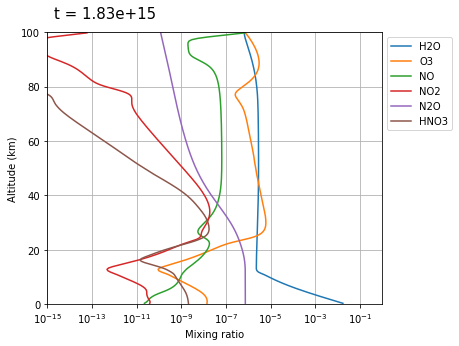

In [12]:
plt.rcParams.update({'font.size': 15})

tn = 0
while tn < 1e17:
    clear_output(wait=True)
    fig,ax = plt.subplots(1,1,figsize=[6,5])
    sol = pc.mole_fraction_dict()
    species = ['H2O','O3','NO','NO2','N2O','HNO3']
    for i,sp in enumerate(species):
        ax.plot(sol[sp],sol['alt'],label=sp)
    ax.set_xscale('log')
    ax.set_ylabel('Altitude (km)')
    ax.set_xlabel('Mixing ratio')
    ax.set_xlim(1e-15,1)
    ax.set_ylim(0,100)
    ax.grid()
    ax.text(0.02, 1.04, 't = '+'%.2e'%tn, \
        size = 15,ha='left', va='bottom',transform=ax.transAxes)
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    plt.show()
    for i in range(10):
        tn = pc.step()

In [13]:
pc.destroy_stepper()

These results are similar to Figure 9 in [the 2021 paper abount the VULCAN](https://arxiv.org/abs/2108.01790) photochemical model. Differences are probably mostly caused by different photolysis cross sections.